In [1]:
from qiskit import *
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit import IBMQ
from qiskit.converters import circuit_to_dag
import json
from qiskit.tools.monitor import job_monitor
%matplotlib inline

### Sbox

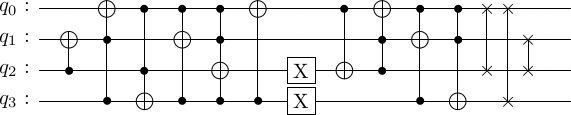

In [23]:
sbox = QuantumCircuit(4)
qubits = [
    [2,1],
    [3,1,0],
    [0,2,3],
    [0,3,1],
    [0,1,3,2],
    [3,0],
    [2],
    [3],
    [0,2],
    [1,2,0],
    [0,3,1],
    [0,1,3]
]

for i in qubits:
    if len(i) == 1:
        sbox.x(i[0])
    elif len(i) == 2:
        sbox.cnot(i[0],i[1])
    elif len(i) == 3:
        sbox.toffoli(i[0],i[1],i[2])
    else:
        sbox.mct(i[:-1],i[-1])

sbox.swap(0,2)
sbox.swap(0,3)
sbox.swap(1,2)

sbox.draw('latex')

In [24]:
sbox_gate = sbox.to_gate()
sbox_gate.name = 'SN'

In [25]:
with open('./latex-saes21/sbox.tex','w') as f:
    data = sbox.draw('latex_source')
    f.write(data)

### INV SBOX

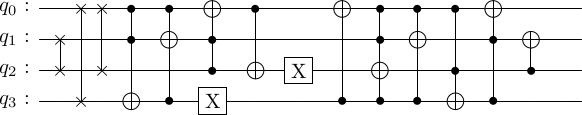

In [26]:
inv_sbox = QuantumCircuit(4)
qubits = [
    [2,1],
    [3,1,0],
    [0,2,3],
    [0,3,1],
    [0,1,3,2],
    [3,0],
    [2],
    [3],
    [0,2],
    [1,2,0],
    [0,3,1],
    [0,1,3]
]

inv_sbox.swap(1,2)
inv_sbox.swap(0,3)
inv_sbox.swap(0,2)

qubits = qubits[::-1]
for i in qubits:
    if len(i) == 1:
        inv_sbox.x(i[0])
    elif len(i) == 2:
        inv_sbox.cnot(i[0],i[1])
    elif len(i) == 3:
        inv_sbox.toffoli(i[0],i[1],i[2])
    else:
        inv_sbox.mct(i[:-1],i[-1])

inv_sbox.draw('latex')

In [27]:
inv_sbox_gate = inv_sbox.to_gate()
inv_sbox_gate.name = 'ISN'

In [28]:
with open('./latex-saes21/inv_sbox.tex','w') as f:
    data = inv_sbox.draw('latex_source')
    f.write(data)

### MC

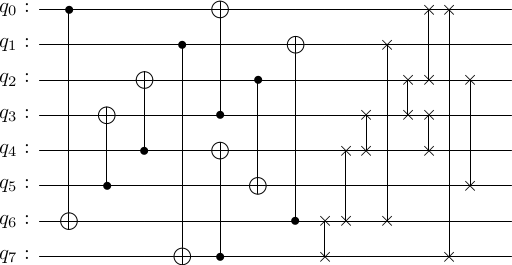

In [29]:
mc = QuantumCircuit(8)
qubits = [
    [0,6],
    [5,3],
    [4,2],
    [1,7],
    [7,4],
    [2,5],
    [3,0],
    [6,1]
]

for i in qubits:
    mc.cnot(i[0],i[1])

mc.swap(6,7)
mc.swap(6,4)
mc.swap(4,3)
mc.swap(3,2)
mc.swap(2,0)

mc.swap(0,7)
mc.swap(1,6)
mc.swap(2,5)
mc.swap(3,4)

mc.draw('latex')

In [31]:
mc_gate = mc.to_gate()
mc_gate.name = 'MC'

In [32]:
with open('./latex-saes21/mc.tex','w') as f:
    data = mc.draw('latex_source')
    f.write(data)

### SR

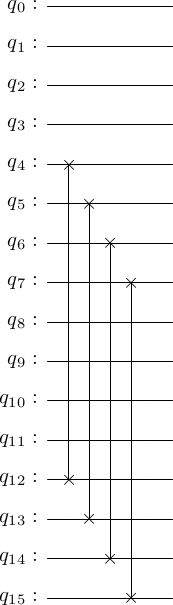

In [33]:
sr = QuantumCircuit(16)
qubits = [
    [4,12],
    [5,13],
    [6,14],
    [7,15],
]

for i in qubits:
    sr.swap(i[0],i[1])

sr.draw('latex')

In [34]:
sr_gate = sr.to_gate()
sr_gate.name = 'SR'

In [35]:
with open('./latex-saes21/sr.tex','w') as f:
    data = sr.draw('latex_source')
    f.write(data)

### Add round key

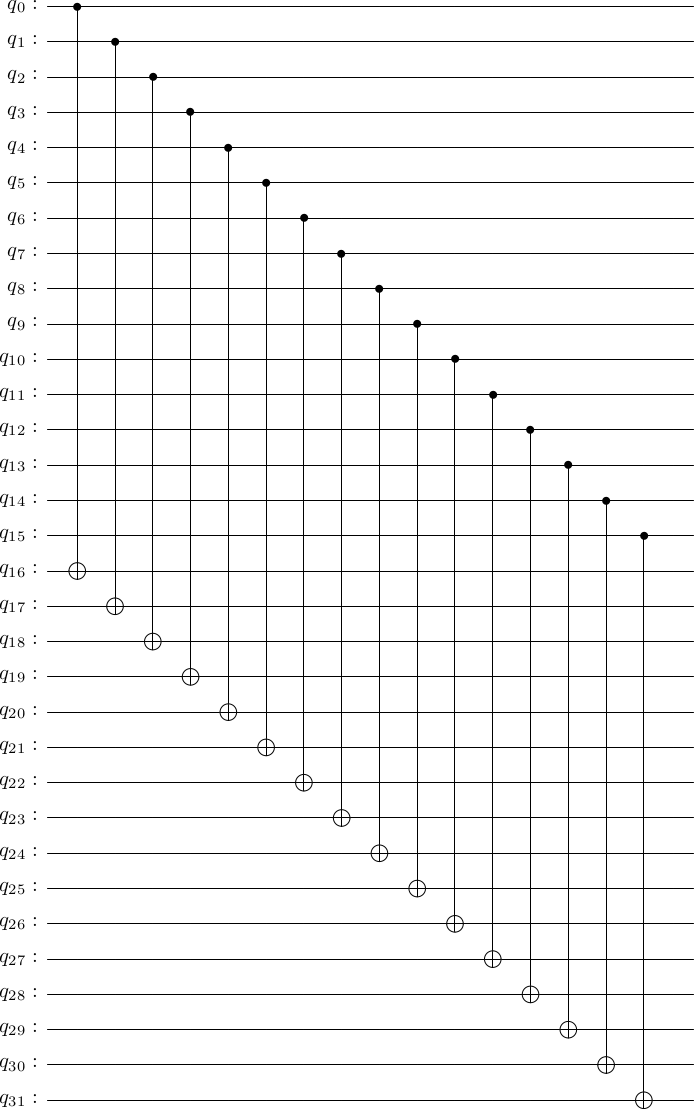

In [38]:
ark = QuantumCircuit(32)
offset = 16
for i in range(16):
    ark.cnot(i, offset + i)
ark.draw('latex')

In [39]:
ark_gate = ark.to_gate()
ark_gate.name = 'AK'

In [40]:
with open('./latex-saes21/ark.tex','w') as f:
    data = ark.draw('latex_source')
    f.write(data)

### round1 key

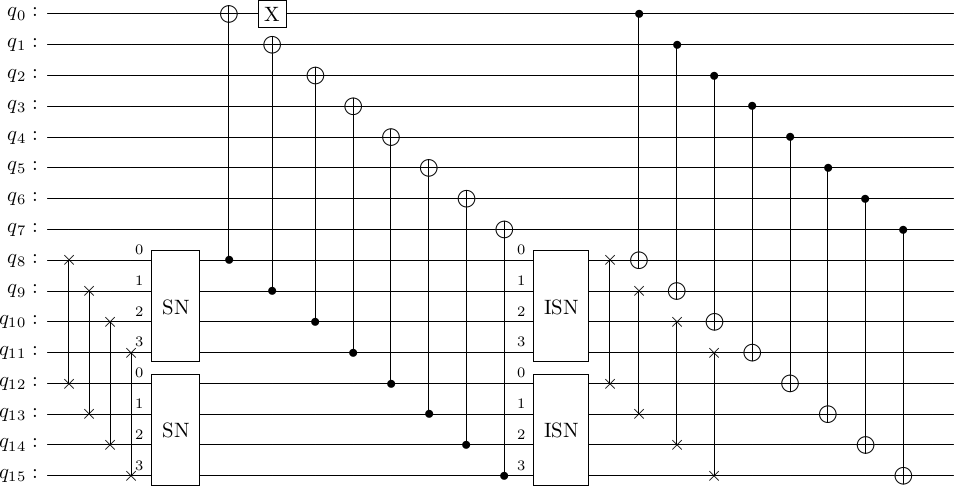

In [51]:
r1k = QuantumCircuit(16)
for i in range(4):
    r1k.swap(8 + i, 12 + i)

r1k.append(sbox_gate, range(8,12))
r1k.append(sbox_gate, range(12,16))

for i in range(8):
    r1k.cnot(8+i, i)

# rcon = 10000000
r1k.x(0)

# Reverse
r1k.append(inv_sbox_gate, range(8,12))
r1k.append(inv_sbox_gate, range(12,16))

for i in range(4):
    r1k.swap(8 + i, 12 + i)

for i in range(8):
    r1k.cnot(i, i+8)

r1k.draw('latex')

In [52]:
r1k_gate = r1k.to_gate()
r1k_gate.name = 'R1K'

In [50]:
with open('./latex-saes21/r1k.tex','w') as f:
    data = r1k.draw('latex_source')
    f.write(data)

### round2 key

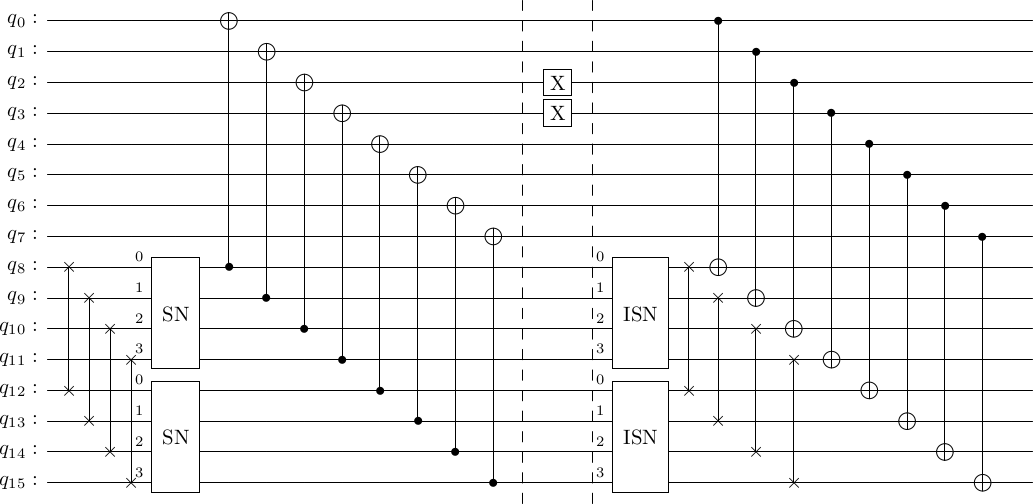

In [53]:
r2k = QuantumCircuit(16)
for i in range(4):
    r2k.swap(8 + i, 12 + i)

r2k.append(sbox_gate, range(8,12))
r2k.append(sbox_gate, range(12,16))

for i in range(8):
    r2k.cnot(8+i, i)

# rcon = 00110000
r2k.x(2)
r2k.x(3)

# Reverse
r2k.append(inv_sbox_gate, range(8,12))
r2k.append(inv_sbox_gate, range(12,16))

for i in range(4):
    r2k.swap(8 + i, 12 + i)

for i in range(8):
    r2k.cnot(i, i+8)


r2k.draw('latex')

In [45]:
r2k_gate = r2k.to_gate()
r2k_gate.name = 'R2K'

In [54]:
with open('./latex-saes21/r2k.tex','w') as f:
    data = r2k.draw('latex_source')
    f.write(data)

### SAES21

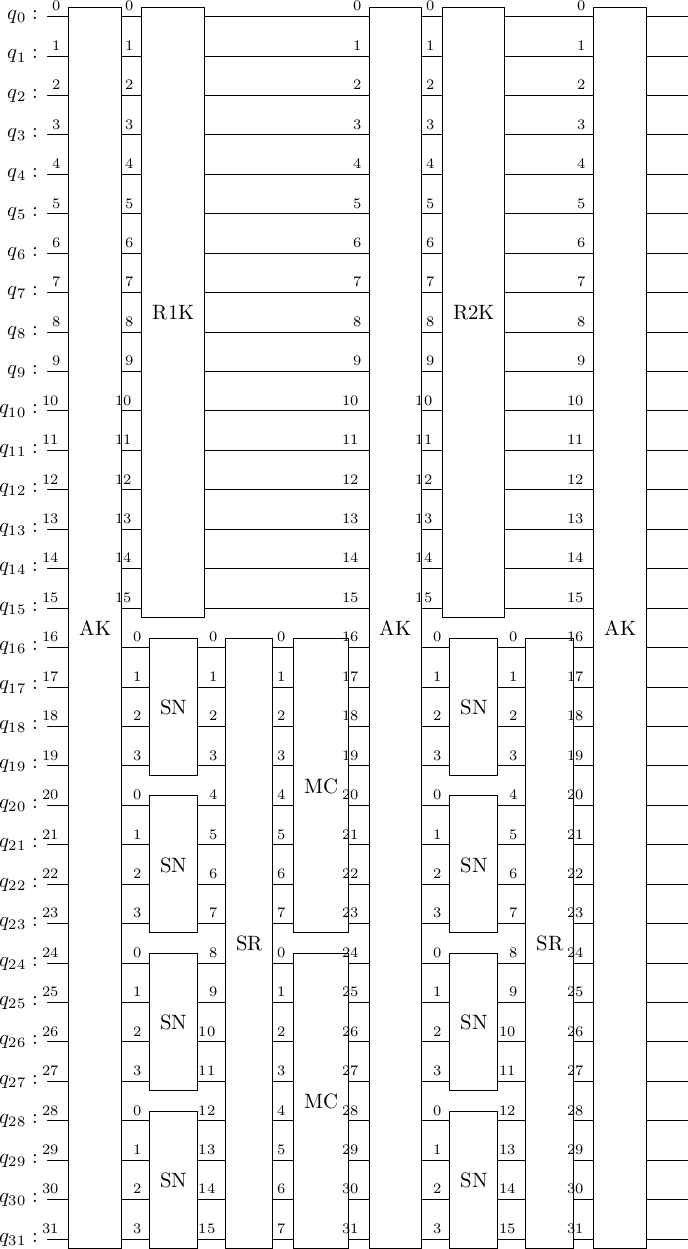

In [56]:
saes = QuantumCircuit(32)

# first 16 qubits for key
# later for plaintext

# xor key with plaintext
saes.append(ark_gate, range(32))

saes.append(sbox_gate, range(16,20))
saes.append(sbox_gate, range(20,24))
saes.append(sbox_gate, range(24,28))
saes.append(sbox_gate, range(28,32))

saes.append(sr_gate, range(16,32))

saes.append(mc_gate, range(16,24))
saes.append(mc_gate, range(24,32))

saes.append(r1k_gate,range(16))
saes.append(ark_gate, range(32))

saes.append(sbox_gate, range(16,20))
saes.append(sbox_gate, range(20,24))
saes.append(sbox_gate, range(24,28))
saes.append(sbox_gate, range(28,32))

saes.append(sr_gate, range(16,32))

saes.append(r2k_gate,range(16))
saes.append(ark_gate, range(32))   


saes.draw('latex')

In [72]:
saes_gate = saes.to_gate()
saes_gate.name = 'SAES'

In [58]:
with open('./latex-saes21/saes.tex','w') as f:
    data = saes.draw('latex_source')
    f.write(data)

In [105]:
saes_inv_gate = saes.inverse()
saes_inv_gate.name = 'SAES+'

In [103]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

ibmqfactory.load_account:WARNING:2022-04-14 15:58:57,287: Credentials are already in use. The existing account in the session will be replaced.


In [64]:
qcomp = provider.get_backend('ibmq_qasm_simulator')
saes_t_qc= transpile(saes, qcomp, optimization_level=2)

In [65]:
saes_t_qc.depth()

59

In [66]:
dict(saes_t_qc.count_ops())

{'cx': 144, 'ccx': 96, 'swap': 90, 'x': 35, 'mcx': 16}

In [ ]:
saes.

In [67]:
qcomp = provider.get_backend('ibmq_qasm_simulator')
saes_inv_t_qc= transpile(saes, qcomp, optimization_level=2)

In [68]:
saes_inv_t_qc.depth()

59

In [69]:
dict(saes_inv_t_qc.count_ops())

{'cx': 144, 'ccx': 96, 'swap': 90, 'x': 35, 'mcx': 16}

### Experiment 1: Verify Oracle for a key and plaintext

In [70]:
msg = '0110111101101011'
key = '1010011100111011'
#cipher = '0000011100111000'

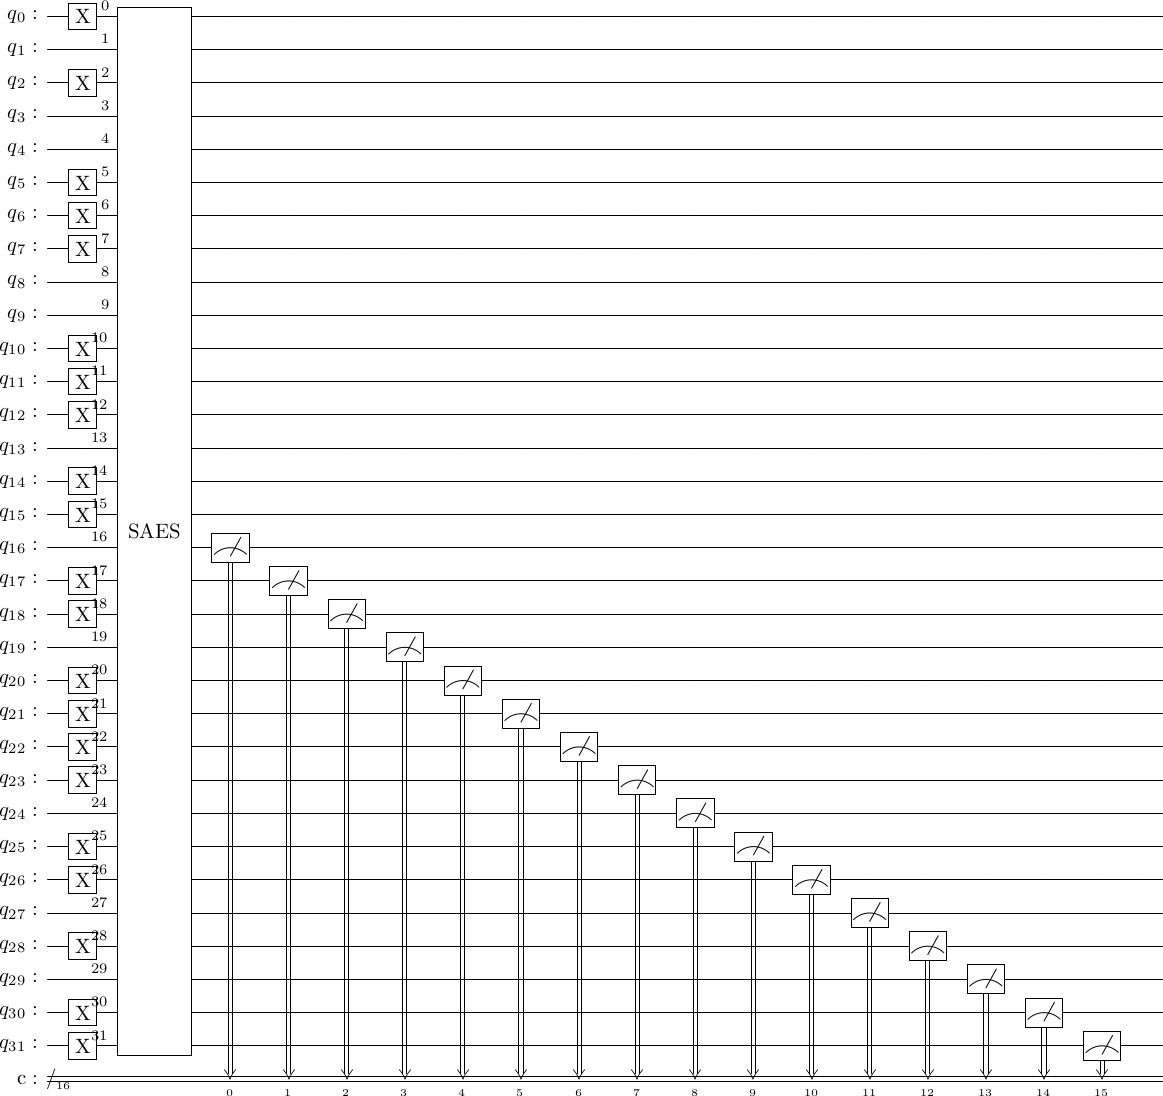

In [73]:
qc = QuantumCircuit(32, 16)

offset = 16
for index, i in enumerate(key):
    if i == '1':
        qc.x(index)
        
for index, i in enumerate(msg):
    if i == '1':
        qc.x(offset + index)

qc.append(saes_gate, range(32))        
qc.measure(np.arange(16,32,1), range(16))
qc.draw('latex')

In [74]:
with open('./latex-saes21/expt1.tex','w') as f:
    data = qc.draw('latex_source')
    f.write(data)

In [75]:
verify_t_qc = transpile(qc, qcomp, optimization_level=2)

In [76]:
verify_t_qc.depth()

61

In [77]:
dict(verify_t_qc.count_ops())

{'cx': 144, 'ccx': 96, 'swap': 90, 'x': 56, 'mcx': 16, 'measure': 16}

###  Experiment 2: Get all states for superposition of all keys

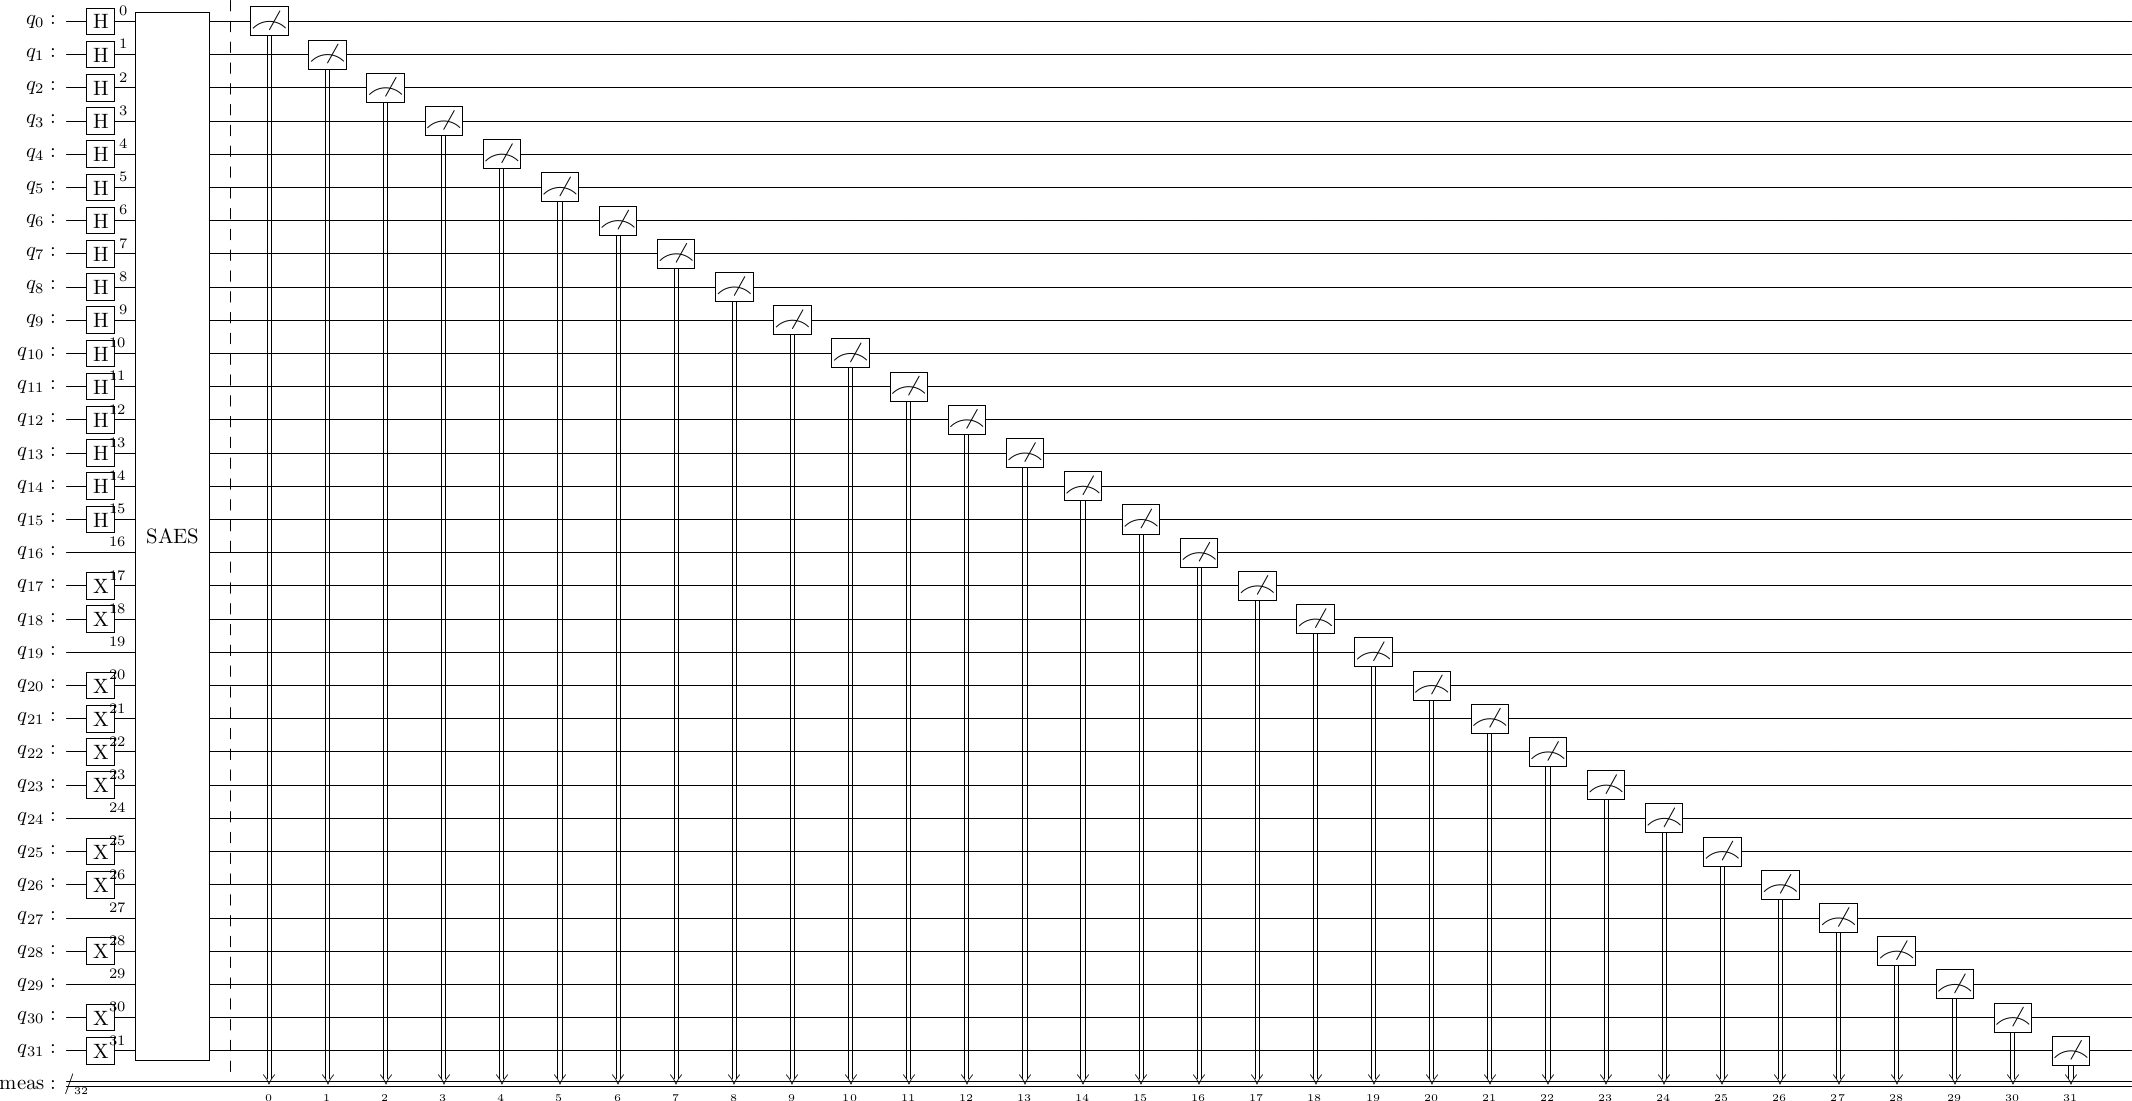

In [78]:
qc = QuantumCircuit(32)

# first 16 qubits for key
# later for plaintext

offset = 16
for i in range(16):
    qc.h(i)
        
for index, i in enumerate(msg):
    if i == '1':
        qc.x(offset + index)

qc.append(saes_gate, range(32))
qc.measure_all()

qc.draw('latex')

In [79]:
super_t_qc = transpile(qc, qcomp, optimization_level=2)

In [80]:
super_t_qc.depth()

61

In [81]:
dict(super_t_qc.count_ops())

{'cx': 144,
 'ccx': 96,
 'swap': 90,
 'x': 46,
 'measure': 32,
 'h': 16,
 'mcx': 16,
 'barrier': 1}

In [82]:
with open('./latex-saes21/expt2.tex','w') as f:
    data = qc.draw('latex_source')
    f.write(data)

### Grover's Oracles

## Only for latex

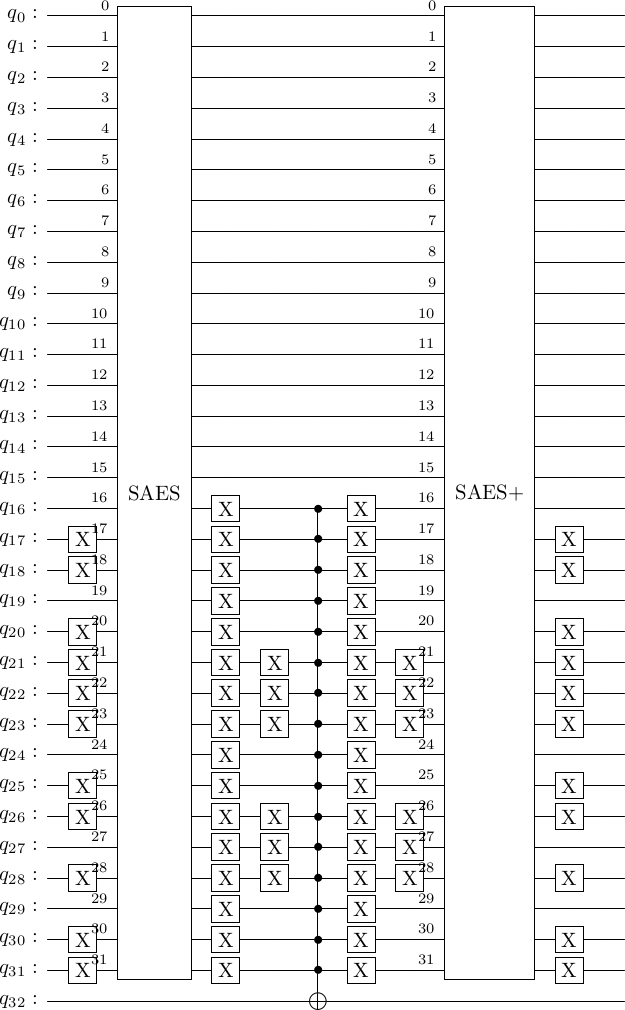

In [106]:
Uf1 = QuantumCircuit(33)

offset = 16

msg = '0110111101101011'
cipher = '0000011100111000'

for index, i in enumerate(msg):
    if i == '1':
        Uf1.x(offset + index)

Uf1.append(saes_gate, range(32))

for index, i in enumerate(cipher):
    if i == '1':
        Uf1.x(offset + index)
        
for i in range(16):
    Uf1.x(offset + i)

qubits = list(np.arange(16,33,1))
Uf1.mct(qubits[:-1],qubits[-1])

for i in range(16):
    Uf1.x(offset + i)

for index, i in enumerate(cipher):
    if i == '1':
        Uf1.x(offset + index)

Uf1.append(saes_inv_gate, range(32))

for index, i in enumerate(msg):
    if i == '1':
        Uf1.x(offset + index)
Uf1.draw('latex')

In [107]:
with open('./latex-saes21/Uf1.tex','w') as f:
    data = Uf1.draw('latex_source')
    f.write(data)

### Will be used later in depth calculations

In [108]:
Uf1 = QuantumCircuit(33)

offset = 16

msg = '0110111101101011'
cipher = '0000011100111000'

for index, i in enumerate(msg):
    if i == '1':
        Uf1.x(offset + index)

Uf1 = Uf1.compose(saes_t_qc, range(32))

for index, i in enumerate(cipher):
    if i == '1':
        Uf1.x(offset + index)
        
for i in range(16):
    Uf1.x(offset + i)

qubits = list(np.arange(16,33,1))
Uf1.mct(qubits[:-1],qubits[-1])

for i in range(16):
    Uf1.x(offset + i)

for index, i in enumerate(cipher):
    if i == '1':
        Uf1.x(offset + index)

Uf1 = Uf1.compose(saes_inv_t_qc, range(32))

for index, i in enumerate(msg):
    if i == '1':
        Uf1.x(offset + index)

## Only for latex

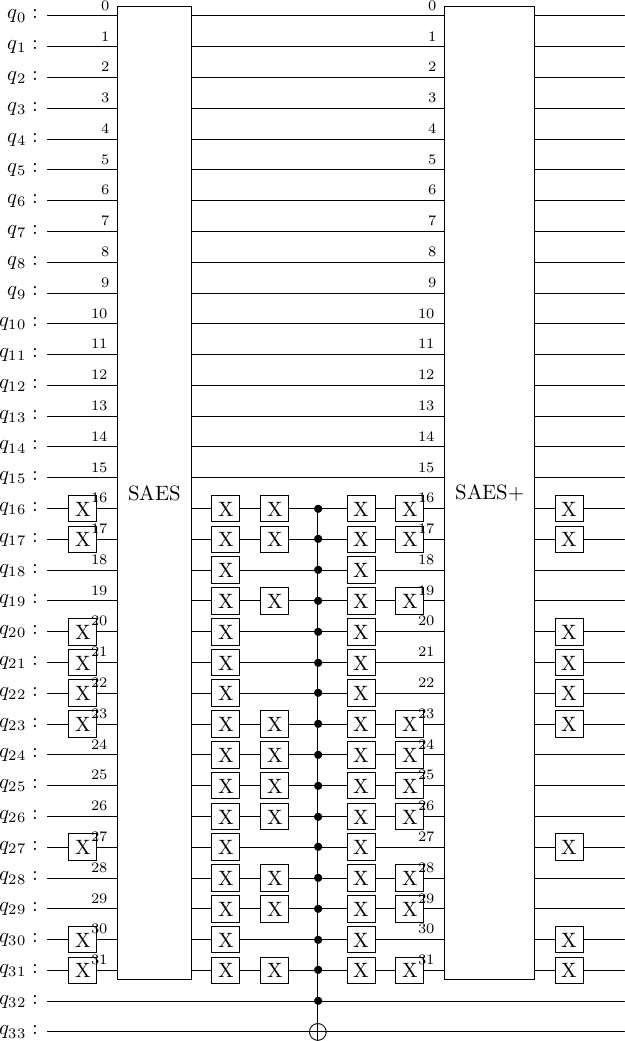

In [147]:
Uf2 = QuantumCircuit(34)

offset = 16

msg = '1100111100010011'
cipher = '1101000111101101'

for index, i in enumerate(msg):
    if i == '1':
        Uf2.x(offset + index)

Uf2.append(saes_gate, range(32))

for index, i in enumerate(cipher):
    if i == '1':
        Uf2.x(offset + index)
        
for i in range(16):
    Uf2.x(offset + i)

qubits = list(np.arange(16,34,1))
Uf2.mct(qubits[:-1],qubits[-1])

for i in range(16):
    Uf2.x(offset + i)

for index, i in enumerate(cipher):
    if i == '1':
        Uf2.x(offset + index)

Uf2.append(saes_inv_gate, range(32))

for index, i in enumerate(msg):
    if i == '1':
        Uf2.x(offset + index)
Uf2.draw('latex')

In [148]:
with open('./latex-saes21/Uf2.tex','w') as f:
    data = Uf2.draw('latex_source')
    f.write(data)

### Will be used later in depth calculations

In [109]:
Uf2 = QuantumCircuit(34)

offset = 16

msg = '1100111100010011'
cipher = '1101000111101101'

for index, i in enumerate(msg):
    if i == '1':
        Uf2.x(offset + index)

Uf2 = Uf2.compose(saes_t_qc, range(32))

for index, i in enumerate(cipher):
    if i == '1':
        Uf2.x(offset + index)
        
for i in range(16):
    Uf2.x(offset + i)

qubits = list(np.arange(16,34,1))
Uf2.mct(qubits[:-1],qubits[-1])

for i in range(16):
    Uf2.x(offset + i)

for index, i in enumerate(cipher):
    if i == '1':
        Uf2.x(offset + index)

Uf2 = Uf2.compose(saes_inv_t_qc, range(32))

for index, i in enumerate(msg):
    if i == '1':
        Uf2.x(offset + index)

### Grover Circuit 1

In [110]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    
#     U_s = qc.to_gate()
#     U_s.name = "U$_s$"
    return qc

In [131]:
qc = QuantumCircuit(33,16)

for i in range(16):
    qc.h(i)

qc.x(32)

inv_gate = diffuser(16)

t = 142

for i in range(t):
    if(i%10 == 0):
        print(i)
    qc.h(32)
    qc = qc.compose(Uf1, range(33))
    qc = qc.compose(inv_gate, range(16))
    
qc.measure(range(16), range(16))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


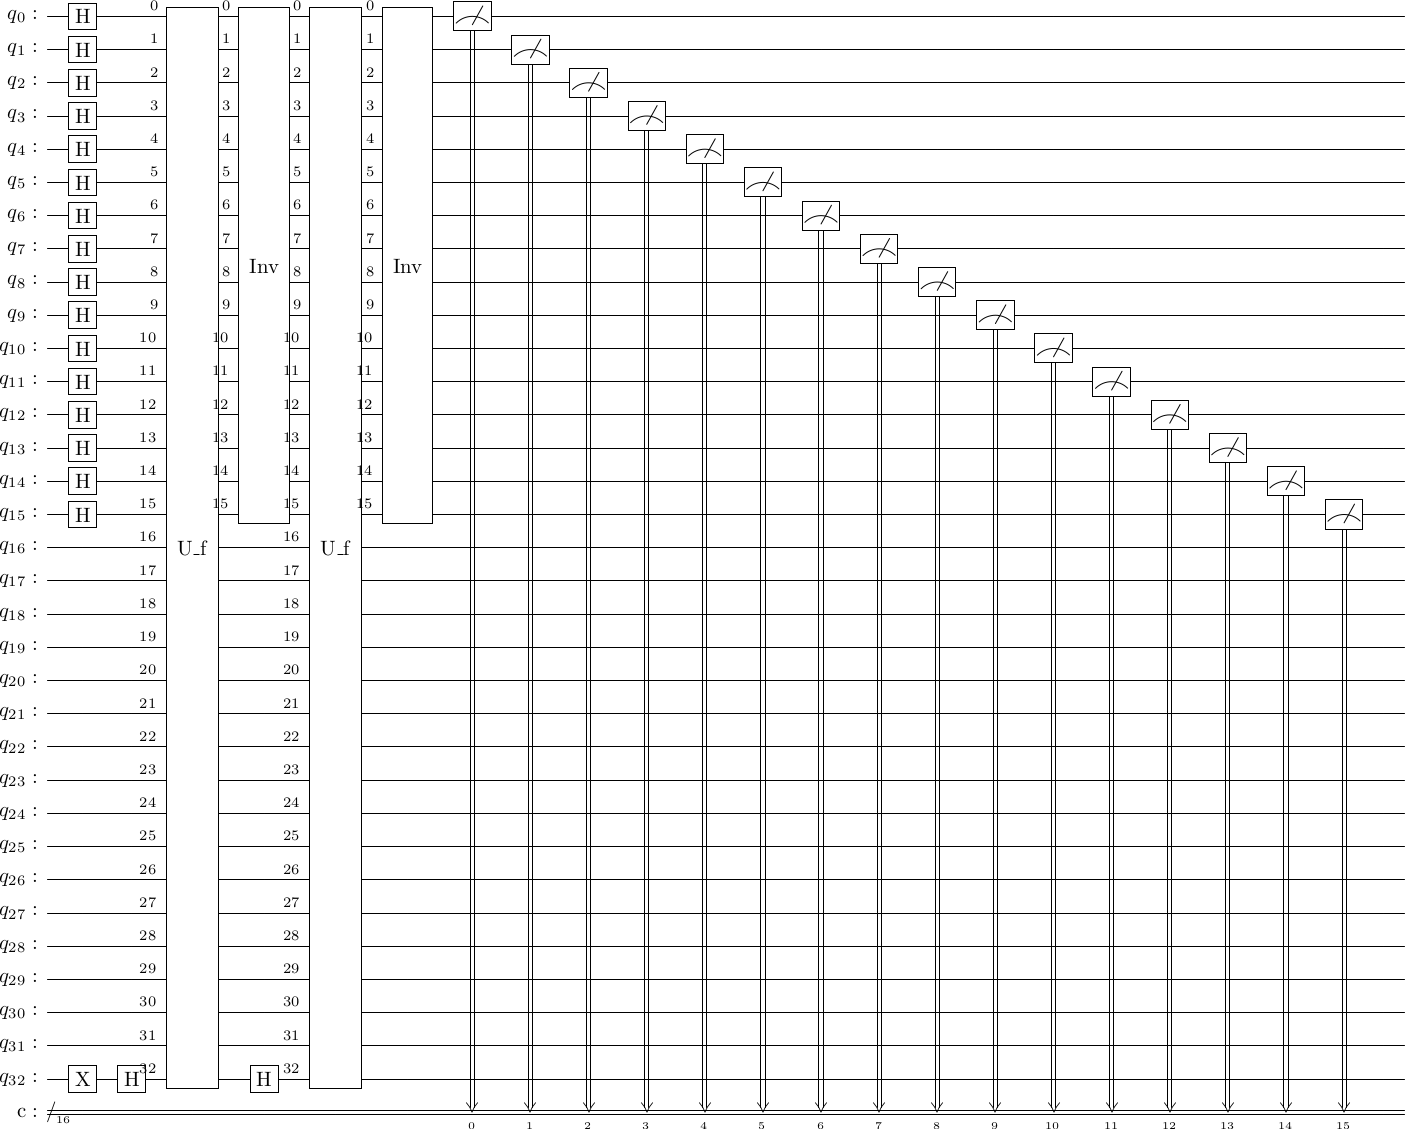

In [127]:
qc.draw('latex')

In [128]:
with open('./latex-saes21/grover-2-iter.tex','w') as f:
    data = qc.draw('latex_source')
    f.write(data)

In [132]:
qc.depth()

18179

In [133]:
qc.count_ops()

OrderedDict([('cx', 40896),
             ('ccx', 27264),
             ('swap', 25560),
             ('x', 23857),
             ('h', 4986),
             ('mcx', 4544),
             ('mcx_gray', 284),
             ('measure', 16)])

### Grover Circuit 2

In [144]:
qc = QuantumCircuit(34,16)

for i in range(16):
    qc.h(i)

qc.x(33)
qc.barrier()
inv_gate = diffuser(16)

t = 142

for i in range(t):
    if(i%10 == 0):
        print(i)   
    
    # Phase Inversion
    qc.h(33)
    qc = qc.compose(Uf1, range(33))
    qc = qc.compose(Uf2, range(34))
    qc = qc.compose(Uf1, range(33))

    # Inversion about mean
    qc = qc.compose(inv_gate, range(16))

# grover_gate = grover_gate_cirq2(t, Uf1_gate, Uf2_gate, inv_gate)
# qc.append(grover_gate, range(34))
qc.measure(range(16), range(16))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


Unable to compile LaTeX. Perhaps you are missing the `qcircuit` package. The output from the `pdflatex` command is in `latex_error.log`.


VisualizationError: '`pdflatex` call did not succeed: see `latex_error.log`.'

In [141]:
with open('./latex-saes21/grover-coupling-1-iter.tex','w') as f:
    data = qc.draw('latex_source')
    f.write(data)

In [145]:
qc.depth()

53680

In [146]:
qc.count_ops()

OrderedDict([('cx', 122688),
             ('ccx', 81792),
             ('swap', 76680),
             ('x', 63049),
             ('mcx', 13632),
             ('h', 4986),
             ('mcx_gray', 568),
             ('measure', 16),
             ('barrier', 1)])